In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

# LOAD DATASET

In [3]:
train = pd.read_csv("./data/train.tsv", sep = "\t", index_col = "PhraseId")
train["Phrase(original)"] = train["Phrase"]
print(train.shape)
train.head(5)

(156060, 4)


,SentenceId,Phrase,Sentiment,Phrase(original)
PhraseId,,,,
1,1,A series of escapades demonstrating the adage ...,1,A series of escapades demonstrating the adage ...
2,1,A series of escapades demonstrating the adage ...,2,A series of escapades demonstrating the adage ...
3,1,A series,2,A series
4,1,A,2,A
5,1,series,2,series


In [4]:
test = pd.read_csv("./data/test.tsv", sep = "\t", index_col = "PhraseId")
test["Phrase(original)"] = test["Phrase"]
print(test.shape)
test.head(5)

(66292, 3)


,SentenceId,Phrase,Phrase(original)
PhraseId,,,
156061,8545,An intermittently pleasing but mostly routine ...,An intermittently pleasing but mostly routine ...
156062,8545,An intermittently pleasing but mostly routine ...,An intermittently pleasing but mostly routine ...
156063,8545,An,An
156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing but mostly routine effort
156065,8545,intermittently pleasing but mostly routine,intermittently pleasing but mostly routine


# PREPROCESSING

## Cleantext -- 1

NLTK(Natural Language Toolkit) provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.

Snowball is a small string processing language designed for creating stemming algorithms for use in Information Retrieval.

In [5]:
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english') 
print(stemmer.stem("disappointments")) #disappoint

In [ ]:
def stem_phrase(phrase):
    words = phrase.split(" ")
    stemmed_words = []

    for word in words:
        stemmed_word = stemmer.stem(word)
        stemmed_words.append(stemmed_word)

    stemmed_phrase = " ".join(stemmed_words)

    return stemmed_phrase

In [6]:
# Train
tqdm.pandas(desc="Stemming... (train)")

train["Phrase"] = train["Phrase"].progress_apply(stem_phrase)

print(train.shape)
train.head()

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
Stemming... (train): 100%|██████████| 156060/156060 [00:15<00:00, 10166.33it/s]

(156060, 4)


,SentenceId,Phrase,Sentiment,Phrase(original)
PhraseId,,,,
1,1,a seri of escapad demonstr the adag that what ...,1,A series of escapades demonstrating the adage ...
2,1,a seri of escapad demonstr the adag that what ...,2,A series of escapades demonstrating the adage ...
3,1,a seri,2,A series
4,1,a,2,A
5,1,seri,2,series


In [7]:
# Test
tqdm.pandas(desc = "Stemming... (test)")

test["Phrase"] = test["Phrase"].progress_apply(stem_phrase)

print(test.shape)
test.head()

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
Stemming... (test): 100%|██████████| 66292/66292 [00:05<00:00, 11261.99it/s]

(66292, 3)


,SentenceId,Phrase,Phrase(original)
PhraseId,,,
156061,8545,an intermitt pleas but most routin effort .,An intermittently pleasing but mostly routine ...
156062,8545,an intermitt pleas but most routin effort,An intermittently pleasing but mostly routine ...
156063,8545,an,An
156064,8545,intermitt pleas but most routin effort,intermittently pleasing but mostly routine effort
156065,8545,intermitt pleas but most routin,intermittently pleasing but mostly routine


## Cleantext 2.1

In [8]:
from wordcloud import WordCloud, STOPWORDS

In [10]:
#nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('english')
extra_stopwords = ['stopWord1','stopWord2']
stopwords.extend(extra_stopwords)

In [11]:
# wordcloud color
def random_color_func(word=None, font_size=None, position=None,  
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * float(random_state.randint(100, 150) / 255.0))
    s = int(73)
    l = int(48)

    return "hsl({}, {}%, {}%)".format(h, s, l)

In [18]:
wordcloud2 = WordCloud().generate(' '.join(text2['Crime Type']))

PhraseId
1         a seri of escapad demonstr the adag that what ...
2         a seri of escapad demonstr the adag that what ...
3                                                    a seri
4                                                         a
5                                                      seri
                                ...                        
156056                                            hearst 's
156057                                forc avuncular chortl
156058                                     avuncular chortl
156059                                            avuncular
156060                                               chortl
Name: Phrase, Length: 156060, dtype: object

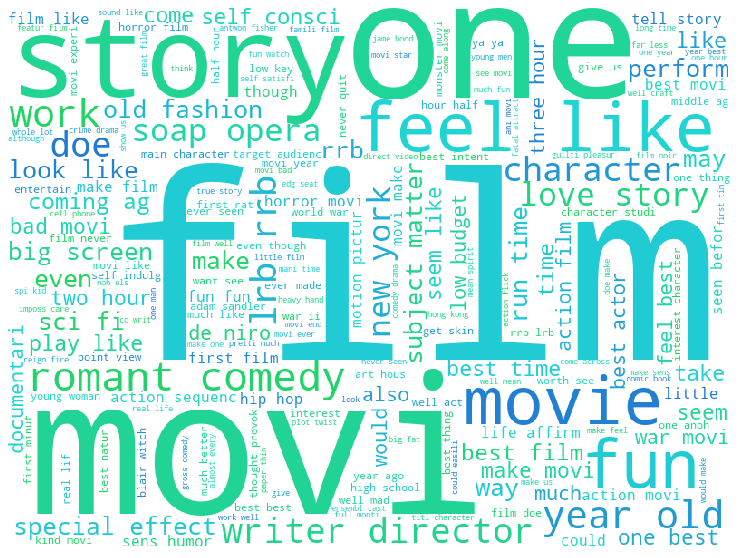

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(stopwords = stopwords,
                      background_color = 'white',
                      width = 800, height = 600,
                      color_func=random_color_func).generate(' '.join(train['Phrase']))

plt.figure(figsize = (15, 10))
plt.axis("off"
plt.imshow(wordcloud)
plt.show()

## Cleantext -- 2.2

In [21]:
def clean_text(phrase):
    phrase = phrase.replace("n't", "not")
    phrase = phrase.replace("not", "no")
    phrase = phrase.replace("hopeless", "bad")
    phrase = phrase.replace("good", "best")
    phrase = phrase.replace("excellent", "best")
    phrase = phrase.replace("funni", "fun")
    phrase = phrase.replace("funny", "fun")
    phrase = phrase.replace("littl", "little")
    phrase = phrase.replace("the movi", "movie")
    phrase = phrase.replace("veri", "very")
    phrase = phrase.replace("onli", "only")
    phrase = phrase.replace("comedi", "comedy")
    phrase = phrase.replace("veri", "very")
    phrase = phrase.replace("stori", "story")
    phrase = phrase.replace("charact", "character")

    return phrase

train["Phrase"] = train["Phrase"].apply(clean_text)
test["Phrase"] = test["Phrase"].apply(clean_text)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(stopwords = stopwords,
                      background_color = 'white',
                      width = 800, height = 600,
                      color_func=random_color_func).generate(' '.join(train['Phrase']))

plt.figure(figsize = (15, 10))
plt.axis("off") # 축에 표시되는 눈금을 제거하는 옵션
plt.imshow(wordcloud) # 이미지가 표시되도록 하는 옵션.
plt.show() # 최종으로 보여주는 옵션.

### one Hot Encode Phrases

**TF-IDF**
$$ \frac{TF}{IDF} $$

* Term frequency  (per sentence)
* Document frequency  (per document)

values uniqueness 1 > 0 (a,the,etc..)
* tree(countVectorizer)
* regression(TFIDF)

When it comes to NLP, even if it is just one thing that changed, tuning has to be re-done such as learning rate alpha.

#### CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 30000, ngram_range = (1,4), stop_words =['the',
'of','to','it','in','that','an','of the','this','his','about','at','or','than','from','in the','are','so','rrb',
'the film','who','lrb','to the','doe','do','for the','director','been','ani','on the'])

vectorizer.fit(train["Phrase"])

In [ ]:
X_train = vectorizer.transform(train["Phrase"])
# applies the params from fiting to data

print(X_train.shape)
X_train

In [ ]:
columns = vectorizer.get_feature_names()# <- vocab
# "not funny" in columns

train_vector = pd.DataFrame(X_train.toarray(), columns= columns)
print(train_vector.shape)

In [ ]:
# Visualize

import matplotlib.pyplot as plt

dictionary = {}

# This takes a while
# This will take each train dataset's word and count the frequency in dictionary form.
for column in train_vector.columns:
    dictionary[column] = train_vector[column].sum()

dictionary_dataframe = pd.DataFrame.from_dict({'word': list(dictionary.keys()), 'count': list(dictionary.values())})
dictionary_dataframe = dictionary_dataframe.sort_values('count', ascending=False)
dictionary_dataframe = dictionary_dataframe[0:100]

%matplotlib inline
import seaborn as sns

figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 64)

sns.barplot(data=dictionary_dataframe, y="word", x="count", ax=ax)
# dictionary_dataframe.to_csv("frequency.csv")

#### TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

char_vectorizer = TfidfVectorizer(analyzer = 'char', 
                                  max_features = 10000, 
                                  ngram_range = (1,9))

char_vectorizer.fit(train["Phrase"])
%time

In [ ]:
word_vectorizer = TfidfVectorizer(analyzer = 'word', 
                                  max_features = 30000, 
                                  ngram_range = (1,4))

word_vectorizer.fit(train["Phrase"])

# Fit and Transform 

Fitting finds the internal parameters of a model that will be used to transform data.

Transforming applies the parameters to data.

You may fit a model to one set of data, and then transform it on a completely different dataset.

In [ ]:
X_train_word = word_vectorizer.transform(train["Phrase"])
print(X_train_word.shape)
X_train_char = char_vectorizer.transform(train["Phrase"])
print(X_train_char.shape)

from scipy.sparse import hstack #vstack, hstack (word, character to merge )
X_train = hstack([X_train_char, X_train_word])
print(X_train.shape)
X_train

In [ ]:
X_test_word = word_vectorizer.transform(test["Phrase"])
print(X_test_word.shape)
X_test_char = char_vectorizer.transform(test["Phrase"])
print(X_test_char.shape)

X_test = hstack([X_test_char, X_test_word])
print(X_test.shape)
X_test

In [ ]:
y_train = train["Sentiment"]

print(y_train.shape)
y_train.head()

# Score 

In [ ]:
from sklearn.linear_model import SGDClassifier

seed = 23

model = SGDClassifier(n_jobs=-1,
                      alpha = 0.00005,
                      random_state=seed)

model

In [ ]:
#cross validation

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

predictions = cross_val_predict(model, X_train, y_train, cv = 5)

score = accuracy_score(y_train, predictions)

print(f"Score = {score.5f}")


In [ ]:
from sklearn.model_selection import cross_val_score, GroupKFold
# from sklearn.cross_validation import cross_val_score, GroupKFold

kfold = GroupKFold(n_splits=5)

score = cross_val_score(model, X_train, y_train, cv=kfold, groups=train["SentenceId"]).mean()

print("Score = {0:.5f}".format(score))

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train)

In [ ]:
params = {
    'booster': 'gblinear',
    'objective': 'multi:softmax',
    'lambda': 2.186753e-03,
    'alpha': 1.286904,
    'lambda_bias': 6.191707e+00,
    'num_class': 5,
    'nthread':2,
}

booster = xgb.train(params, dtrain, num_boost_round=98)
booster

In [ ]:
dtest = xgb.DMatrix(X_test.toarray())

# Predictions

In [ ]:
predictions = booster.predict(dtest)
print(predictions.shape)
predictions[0:10]

# Submit

In [ ]:
submission = pd.read_csv("./data/sampleSubmission.csv", index_col="PhraseId")

submission["Sentiment"] = predictions

print(submission.shape)
submission.head()

In [ ]:
from datetime import datetime

current_date = datetime.now()
current_date = current_date.strftime("%Y-%m-%d_%H-%M-%S")

desc = ""
sign = "silverrain"

filename = "{date}_{score:.5f}_{desc}_{sign}.csv".format(date=current_date, 
                                                         score=score, 
                                                         desc=desc, 
                                                         sign=sign)
# filename = f"{date}_{score}_{desc}_{sign}.csv"
filepath = "{filename}".format(filename=filename)

In [ ]:
submission.to_csv(filepath)